In [1]:
PATH='/home/kirana/Documents/phd/exp3_autoencoder'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/filmtrust'

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import sklearn
import torch
import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [3]:
[df, df_train,df_valid,df,df_ratings,dfflagtrain,dfflagvalid,idx_to_user,\
             idx_to_movie,movie_to_idx,user_to_idx]=pickle.load(open(f'{DATAPATH}/itemreads.pkl','rb'))

## Dataset and DataLoader

In [4]:
class autoencdata (Dataset):
    def __init__(self,dfX,dfXv):
        self.dfX,self.dfXv=dfX,dfXv
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor(self.dfXv.iloc[idx].values)

In [5]:
dstrain=autoencdata(df_train, df_valid)
#dsvalid=autoencdata(df_valid)

In [11]:
bs=8

In [12]:
# Create a DataLoader object
dltrain=DataLoader(dstrain,batch_size=bs,shuffle=False)
#dlvalid=DataLoader(dsvalid,batch_size=bs,shuffle=False) 

In [13]:
df['rating'].min(),df['rating'].max()

(0.5, 4.0)

In [14]:
df_train.shape

(2071, 1508)

In [15]:
len(dltrain)

259

## Create the Model Architecture for the Encoder

In [97]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [98]:
class autoencoder (nn.Module):    
    def __init__(self,n_inp,hidden=[50,10],dropouts=[0,0,0],rating_range=[0.5,5]):
        super().__init__()
        self.n_inp,self.hidden,self.dropouts,self.rating_range=n_inp,hidden,dropouts,rating_range
        encoder=[hidden_layer(n_inp if i==0 else hidden[i-1],hidden[i],dropouts[i],\
                              nn.Sigmoid() if i<len(hidden)-1 else nn.Tanh()) for i in range(len(hidden))]
        self.encoder=nn.Sequential(*encoder)
        hidden=hidden[::-1]
        num_steps=len(hidden)-1
        dropouts=dropouts[num_steps:]
        decoder=[hidden_layer(hidden[i],hidden[i+1] if i<len(hidden)-1 else n_inp,dropouts[i]) for i in range(len(hidden)-1)]
        self.decoder=nn.Sequential(*decoder)
        self.fc=nn.Linear(hidden[-1],n_inp)
        self.initialize()
        self.criterion=nn.MSELoss()
    
    def initialize(self):
        for x in self.encoder:
            nn.init.kaiming_normal_(x[0].weight.data)
        for x in self.decoder:
            nn.init.kaiming_normal_(x[0].weight.data)

    def forward (self,Xb):
        
        encoded=self.encoder(Xb)
        decoded=self.decoder(encoded)
        out=self.fc(decoded)
        outv=out.clone()
        out[Xb==0]=0
        loss=self.criterion(out,Xb)
        return outv,loss, out

In [133]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.2,0.2,0])

In [134]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1508, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
  )
  (fc): Linear(in_features=50, out_features=1508, bias=True)
  (criterion): MSELoss()
)

In [101]:
for Xb, Xb_v in dltrain:
    print (Xb)
    break

tensor([[2.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.5000],
        [4.0000, 0.0000, 0.0000,  ..., 0.0000, 4.0000, 3.0000],
        [3.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0000],
        ...,
        [3.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [3.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.0000]])


In [102]:
Xb.size()

torch.Size([8, 1508])

In [103]:
Xb.squeeze(0)

tensor([[2.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.5000],
        [4.0000, 0.0000, 0.0000,  ..., 0.0000, 4.0000, 3.0000],
        [3.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.0000],
        ...,
        [3.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [3.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 3.0000]])

In [104]:
preds,loss,preds_train=autoenc.forward(Xb)

In [105]:
loss.backward()

In [106]:
preds.size()

torch.Size([8, 1508])

In [107]:
nn.MSELoss

torch.nn.modules.loss.MSELoss

In [108]:
device="cuda:0"

In [109]:
wd=1e-6
#wd=1e-1

In [110]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
#optimizer=torch.optim.SGD(model_sentiment.parameters(),lr=1e-2,momentum=0.9, weight_decay=wd)
metric_fn=None

In [111]:
len(dltrain)

259

In [112]:
import matplotlib.pyplot as plt

In [113]:
dltrain.batch_size

8

In [114]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=6,start_lr=2e-2, end_lr=5e-4):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        
    def fit (self,Xb,Xb_v,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss,preds_train=self.model(Xb)
        # denominator is the average of the error with non-zero ratings

        mean_corrector = Xb.size(0)*Xb.size(1)/(torch.sum(Xb > 0).float() + 1e-10)
        mean_corrector_v = Xb_v.size(0)*Xb_v.size(1)/(torch.sum(Xb_v > 0).float() + 1e-10)

        with torch.no_grad():
            
            preds[Xb_v==0]=0
            loss_v=self.model.criterion(preds,Xb_v)
            
            if self.metric_fn is not None:
                acc=self.metric_fn(preds,Yb.view(-1),self.device)
                acc=acc.item()

                if 1==0:
                    if mode_train:
                        self.trainY.append(Yb.view(-1))
                        self.preds.append(preds.data)
                    else:
                        self.actual.append(Yb.view(-1))
                        self.preds_valid.append(preds.data)
            else:
                acc=0
                acc_v=0
            del preds
        
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=torch.sqrt(loss.item()*mean_corrector)
        myloss_v=torch.sqrt(loss_v.item()*mean_corrector_v)
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc,myloss_v,acc_v
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_loss_v,epoch_acc_v=0,0

        for Xb,Xb_v in iterator:
            Xb=Xb.to(self.device)
            Xb_v=Xb_v.to(self.device)
            #Xb=Xb.squeeze(0)
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            

            loss,acc,loss_v,acc_v=self.fit(Xb,Xb_v,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)
            
            epoch_loss+=loss
            epoch_acc+=acc
            epoch_loss_v+=loss_v
            epoch_acc_v+=acc_v
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)} {epoch_loss_v/(k)} ')  
                    torch.cuda.empty_cache()
        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_loss_v=epoch_loss_v/len(iterator)
        epoch_acc_v=epoch_acc_v/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_loss_v,epoch_acc_v
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):
        
        
            
        
        for epoch in range(n_epochs):                

            loss,acc,lossv,accv=self.run_epoch(dltrain,True)
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss}  Valid Loss:{lossv} ')
  
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    #    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                #param_group['weight_decay']=self.wd
          
     

In [135]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.2,0.2,0]).to(device)
wd=1e-7
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0)

In [136]:
autoenc

autoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1508, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=50, out_features=10, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.2)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=50, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.2)
    )
  )
  (fc): Linear(in_features=50, out_features=1508, bias=True)
  (criterion): MSELoss()
)

In [137]:
len(dltrain)

259

In [138]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

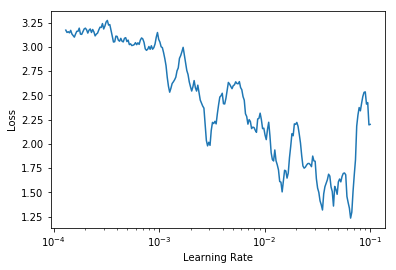

In [139]:
learner.plot_lrs(10)

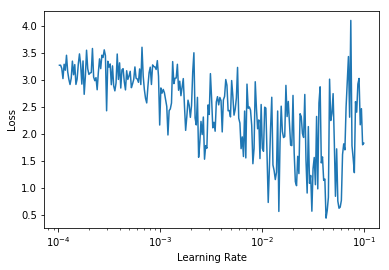

In [140]:
learner.plot_lrs(1)

In [159]:
autoenc=autoencoder(df_train.shape[1],[50,10],[0.2,0.2,0]).to(device)
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=0,start_lr=3e-2,end_lr=5e-4)

In [160]:
learner.run_epochs(dltrain,None,3)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.2846968173980713  Valid Loss:0.9597718715667725 
Epoch:1 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0455414056777954  Valid Loss:0.8242272734642029 
Epoch:2 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0372811555862427  Valid Loss:0.7770411968231201 


In [161]:
optimizer=torch.optim.Adam(autoenc.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(autoenc,optimizer,None,device,0,1000,0.25,cycle_mult=3,start_lr=5e-3,end_lr=5e-4)

In [162]:
learner.run_epochs(dltrain,None,3)

Epoch:0 Learning rate 0.005 Weight Decay 1e-07 Train Loss:1.0642544031143188  Valid Loss:0.8095928430557251 
Epoch:1 Learning rate 0.0023207944168063895 Weight Decay 1e-07 Train Loss:0.9502933621406555  Valid Loss:0.7964579463005066 
Epoch:2 Learning rate 0.001077217345015942 Weight Decay 1e-07 Train Loss:0.9163291454315186  Valid Loss:0.7504302859306335 


In [163]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [164]:
item_mtx_1_weights.shape, item_mtx_2_weights.shape

((50, 1508), (10, 50))

In [165]:
df_train.shape

(2071, 1508)

In [166]:
from scipy.special import expit

df_train_item_autoenc=np.tanh(expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T)
df_valid_item_autoenc=np.tanh(expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T)

In [167]:
df_train_item_autoenc=expit(df_train@item_mtx_1_weights.T)@item_mtx_2_weights.T
df_valid_item_autoenc=expit(df_valid@item_mtx_1_weights.T)@item_mtx_2_weights.T

In [168]:
df_train_item_autoenc.shape

(2071, 10)

In [169]:
df_valid_item_autoenc.shape

(2071, 10)

In [170]:
df_train.shape, df_valid.shape

((2071, 1508), (2071, 1508))

In [171]:
autoenc.encoder[0][0].weight.data.shape

torch.Size([50, 1508])

In [172]:
autoenc.encoder[1][0].weight.data.shape

torch.Size([10, 50])

In [173]:
item_mtx_1_weights=autoenc.encoder[0][0].weight.data.cpu().numpy()
item_mtx_2_weights=autoenc.encoder[1][0].weight.data.cpu().numpy()

In [174]:
df_train_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_train_item_autoenc.shape[1])]

In [175]:
df_valid_item_autoenc.columns=['item_autoenc'+str(i) for i in range(df_valid_item_autoenc.shape[1])]

In [176]:
df_train_item_autoenc.reset_index(inplace=True)

In [177]:
df_valid_item_autoenc.reset_index(inplace=True)

In [178]:
import pickle
pickle.dump([df_train_item_autoenc, df_valid_item_autoenc,item_mtx_1_weights,item_mtx_2_weights],open(f'{DATAPATH}/inter/item_autoenc_weights.pkl','wb'))